In [1]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
def prepare_boston_data():
    # подгружаем boston dataset
    data = load_boston()
    X, y = data['data'], data['target']

    # нормализуем X
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

    # добавляем столбец свободных членов (bias линейной модели)
    n = X.shape[0]  # количество строк
    X = np.hstack([np.ones(n).reshape(n, 1), X])

    return X, y

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'mse: {mse:.2f}, rmse: {rmse:.2f}')

Обернем написанную нами линейную регрессию методом матричных операций в класс:

In [3]:
class LinRegAlgebra():
    def __init__(self):
        self.theta = None
        self.X = None
            
    def fit(self, X, y):
        self.theta = (np.linalg.inv((X.T).dot(X))).dot((X.T).dot(y))
            
    def predict(self, X):
        if self.theta is None:
            raise Exception("You should train the model first")
        return X.dot(self.theta)

In [4]:
# пробуем модель на всем датасете
X, y = prepare_boston_data()
model = LinRegAlgebra()
model.fit(X, y)
y_pred = model.predict(X)
print_regression_metrics(y,y_pred)

mse: 21.89, rmse: 4.68


In [5]:
# пробуем модель на train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model_train = LinRegAlgebra()
model_train.fit(X_train,y_train)
y_pred = model.predict(X_test)
print_regression_metrics(y_test,y_pred)

mse: 13.71, rmse: 3.70


Сделаем базовый абстрактный класс для регрессии:

In [6]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self._theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def fit(self, X, y, start_theta, message=True):
        self._theta = self.optimize(X, y, start_theta, message)
    
    def optimize(self, X, y, start_theta):
        raise NotImplementedError()

    def grad_func(self, X, y, theta):
        raise NotImplementedError()
    
    def gradient_step(self, theta, alpha, theta_grad):
        return theta - alpha*theta_grad

    def predict(self, X):
        if self._theta is None:
            raise Exception('You should train the model first')
        return X.dot(self._theta)

А теперь класс с моделью классической линейной регрессии

In [7]:
class LinReg(RegOptimizer):
    
    def optimize(self, X, y, start_theta, message): # функция градиентного спуска по кол-ву итераций
        theta = start_theta.copy()
                
        for i in range(self._n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad, self._alpha)
            
        return theta
        
    def grad_func(self, X, y, theta): # конкретизируем градиент для классической линейной регрессии
        n = X.shape[0]
        return (1/n)*(X.T).dot(X.dot(theta)-y)

In [8]:
alpha = 0.01
n_iters = 1000
start_theta = np.ones(X.shape[1])

model_grad = LinReg(alpha, n_iters)
model_grad.fit(X, y, start_theta)
y_pred = model_grad.predict(X)

print_regression_metrics(y, y_pred)

mse: 22.21, rmse: 4.71


Сделайте для градиентного спуска остановку алгоритма, если максимальное из абсолютных значений компонент градиента становится меньше 0.01. Для градиентного спуска установите alpha = 0.2.

На какой итерации останавливается градиентный спуск?

In [9]:
class LinRegFast(RegOptimizer):
    
    def optimize(self, X, y, start_theta, message): # функция градиентного спуска по кол-ву итераций
        theta = start_theta.copy()
                
        for i in range(self._n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad, self._alpha)
            if np.max(theta_grad) < 0.01:
                break
        
        if message:
            print('Model training completed successfully')
            print(f'Number of iterations: {i}')
            
        return theta
        
    def grad_func(self, X, y, theta): # конкретизируем градиент для классической линейной регрессии
        n = X.shape[0]
        return (1/n)*(X.T).dot(X.dot(theta)-y)

In [10]:
alpha = 0.2
n_iters = 1000
start_theta = np.ones(X.shape[1])

model_grad_fast = LinRegFast(alpha, n_iters)
model_grad_fast.fit(X, y, start_theta)
y_pred = model_grad_fast.predict(X)

print_regression_metrics(y, y_pred)

Model training completed successfully
Number of iterations: 212
mse: 21.90, rmse: 4.68


In [11]:
# Сравните скорость обучения градиентным спуском и матричными операциями.
model = LinRegAlgebra()
print('Матричный метод: ')
%timeit model.fit(X, y)

model_grad = LinReg(alpha, n_iters)
print('Градиентный спуск 1000 итераций: ')
%timeit model_grad.fit(X, y, start_theta)

model_grad_fast = LinRegFast(alpha, n_iters)
print('Градиентный спуск по условию: ')
%timeit model_grad_fast.fit(X, y, start_theta, message=False)


Матричный метод: 
72.9 µs ± 258 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Градиентный спуск 1000 итераций: 
9.09 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Градиентный спуск по условию: 
3.12 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Добавьте к признакам нелинейной модели квадрат признака DIS и переобучите модель. Какой получился RMSE? Подсказка: используйте написанную нами линейную регрессию методом матричных операций.

In [12]:
def prepare_boston_data_new():
    # подгружаем boston dataset
    data = load_boston()
    X, y = data['data'], data['target']
    
    # добавляем к признакам нелинейной модели квадрат признака DIS
    ind = np.where(data.feature_names=='DIS')[0] # индекс столбца с признаком DIS
    #X = np.hstack([X,(X[:,ind])**2])
    
    X = np.hstack([X, np.sqrt(X[:, 5:6]), X[:, 6:7] ** 3, (X[:,ind])**2])
    
    # нормализуем X
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
    
    # добавляем столбец свободных членов (bias линейной модели)
    n = X.shape[0]  # количество строк
    X = np.hstack([np.ones(n).reshape(n, 1), X])
    
    return X, y

In [14]:
X, y = prepare_boston_data_new()

model = LinRegAlgebra()
model.fit(X,y)
y_pred = model.predict(X)
print_regression_metrics(y, y_pred)

mse: 16.06, rmse: 4.01


In [55]:
def train_validate(X, y):
    # Разбить данные на train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)#, random_state=1)

    # Создать и обучить линейную регрессию
    linreg_alg = LinRegAlgebra()
    linreg_alg.fit(X_train, y_train)

    # Сделать предсказания по валидционной выборке
    y_pred = linreg_alg.predict(X_valid)

    # Посчитать значение ошибок MSE и RMSE для валидационных данных
    print_regression_metrics(y_valid, y_pred)

In [16]:
# Подготовить данные без модификации признаков
X, y = prepare_boston_data_new()
# Провести эксперимент
train_validate(X, y)

mse: 13.59, rmse: 3.69


In [17]:
def prepare_boston_data_new2():
    # подгружаем boston dataset
    data = load_boston()
    X, y = data['data'], data['target']
    
    X = np.hstack([X, np.sqrt(X[:, 5:6]), X[:, 6:7] ** 3])
    
    # нормализуем X
    #X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
    
    # добавляем столбец свободных членов (bias линейной модели)
    n = X.shape[0]  # количество строк
    X = np.hstack([np.ones(n).reshape(n, 1), X])
    
    return X, y

In [18]:
# Подготовить данные без модификации признаков
X, y = prepare_boston_data_new2()
# Провести эксперимент
train_validate(X, y)

mse: 14.28, rmse: 3.78


In [50]:
def prepare_boston_data_poly():
    # подгружаем boston dataset
    data = load_boston()
    X, y = data['data'], data['target']
    
    X = np.hstack([X, np.sqrt(X[:,[5]])])
    
    # нормализуем X
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
    
    # добавляем столбец свободных членов (bias линейной модели)
    n = X.shape[0]  # количество строк
    X = np.hstack([np.ones(n).reshape(n, 1), X])
    
    return X, y

In [80]:
# Подготовить данные без модификации признаков
X, y = prepare_boston_data_poly()
# Провести эксперимент
train_validate(X, y)

mse: 15.68, rmse: 3.96


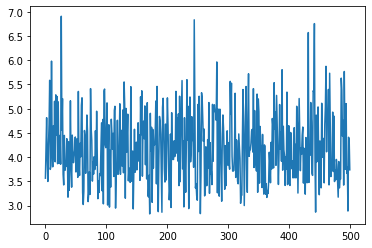

Mean rmse: 4.196296210420031


In [92]:
rmse = []
for i in range(500):
    X,y = prepare_boston_data_new()
    # Разбить данные на train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)#, random_state=1)

    # Создать и обучить линейную регрессию
    linreg_alg = LinRegAlgebra()
    linreg_alg.fit(X_train, y_train)

    # Сделать предсказания по валидционной выборке
    y_pred = linreg_alg.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    rmse.append(np.sqrt(mse))

plt.plot(rmse)
plt.show()
print(f"Mean rmse: {np.mean(rmse)}")